In [15]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np

import itertools
from sklearn.metrics import pairwise_distances

from Nback_tasks import ItemRecognitionTask
from Nback_models import ItemRecognitionEM
import context_tools as ct

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def run_model(net,task,neps,ntrials,setsize,training=True,verb=True):
  
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)

  score = -np.ones([neps,ntrials])
  loss = -np.ones([neps])

  for ep in range(neps):
#     task.sample_stokens()
    # gen stim, forward prop
    
    C,S,ytarget = task.gen_ep_data(ntrials,setsize)
    yhat = net(C,S)
    # scoring, backprop
    score[ep] = (maxsoftmax(yhat) == ytarget).squeeze()
    ep_loss = 0
    for trial in range(ntrials):
      tr_loss = lossop(yhat[trial],ytarget[trial])
      ep_loss += tr_loss
    if training:
      optiop.zero_grad()
      ep_loss.backward(retain_graph=True)
      optiop.step()
    # record and print
    loss[ep] = ep_loss
    if verb and ep%(neps/10)==0:
      print(ep/neps,ep_loss.detach().numpy())
  return loss,score

In [27]:
sedim = 10
cedim = 3
stsize = 25
task = ItemRecognitionTask(sedim,cedim,ntokens=150)
net = ItemRecognitionEM(sedim,cedim,stsize)

In [58]:
ntrials = 10
setsize = 5
tr_neps = 1
_ = run_model(net,task,tr_neps,ntrials,setsize,training=False)


tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0]])
0.0 6.631039


In [10]:
ntrials = 5
setsize = 3
tr_neps = 200000
tr_loss,tr_sc = run_model(net,task,tr_neps,ntrials,setsize,training=True)


0.0 3.547554
0.1 3.406775
0.2 3.4672813
0.3 3.4664383
0.4 3.6629076
0.5 2.8284144
0.6 2.9252326
0.7 3.1615787
0.8 3.8715484
0.9 2.37055


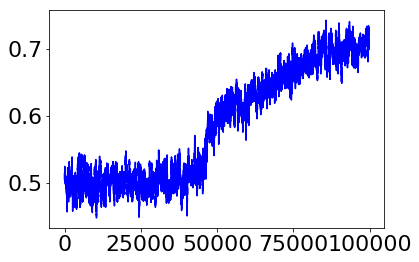

In [11]:
# plt.plot(tr_loss,c='r')
tr_acc = tr_sc.mean(1)
plt.plot(mov_avg(tr_acc,200),c='b')

In [12]:
neps_ev = 1000
ev_loss,ev_score = run_model(net,task,neps_ev,ntrials,setsize,training=False,verb=False)

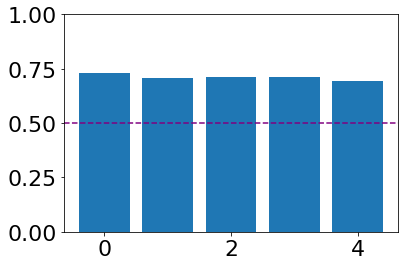

In [14]:
M = ev_score.mean(0)
plt.bar(range(ntrials),M)
plt.ylim(0,1)
plt.axhline(0.5,c='purple',ls='--')

In [6]:
def mov_avg(arr,wind=20):
  ma = -np.ones(len(arr)-wind)
  for idx in range(len(arr)-wind):
    ma[idx] = arr[idx:idx+wind].mean()
  return ma

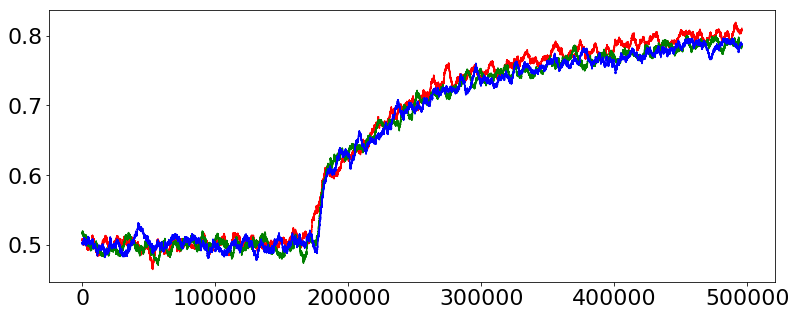

In [115]:


plt.figure(figsize=(13,5))
cL = ['r','g','b']
for t in range(3):
  plt.plot(mov_avg(score[:,t],4000),c=cL[t])

# FROM PARENT BRANCH: serial recall

- serial recall regression problem
- list of items is presented, same list needs to be returned

- two approaches:
    - pure lstm, multi-trial, context drifts on 2 timescales
        - set-size arises from PI and serial order estimate failures
    - lstm+EM, single item retrieved at a time, retrieved item used to query EM
        - memory IOR is hard coded



### todo
- train model with true current context

In [164]:
sedim = 9
task = SerialRecallTask(sedim)
stsize = 30
net = SerialRecallEM(sedim,stsize)

In [165]:
training = True
neps = 50000

ntrials = 4
setsize = 5

lossop = tr.nn.MSELoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.001)

loss = -np.ones(neps)

# data generating option:
C,S,Y = task.gen_ep_data(ntrials,setsize)
seqlen = len(C)
# loop
score = -np.ones([neps,seqlen])    
for ep in range(neps):
#   if ep%(neps/10)==0:
#     if verb:print(ep/neps)
  # gen stim
  C,S,ytarget = task.gen_ep_data(ntrials,setsize)
  # forward prop
  yhat = net(C,S)
  # reshape
  ytarget = ytarget.view(-1,sedim)
  yhat = yhat.view(-1,sedim)
  # backprop
  eploss = 0
  for tstep in range(seqlen):
    prloss = lossop(yhat[tstep],ytarget[tstep])
    eploss += prloss
    optiop.zero_grad()
    prloss.backward(retain_graph=True)
    optiop.step()
  loss[ep] = eploss
  



Text(0.5,0,'epoch')

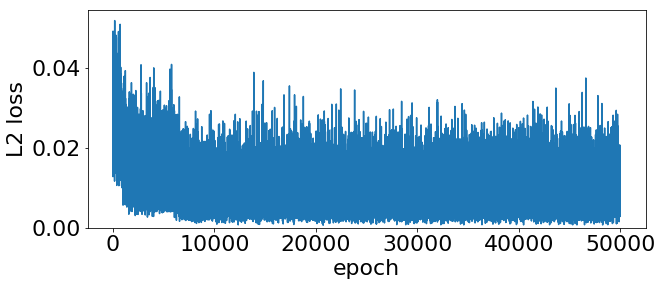

In [167]:
plt.figure(figsize=(10,4))
plt.plot(loss)
plt.ylim(0)
# plt.xlim(-100,5100)
plt.ylabel('L2 loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

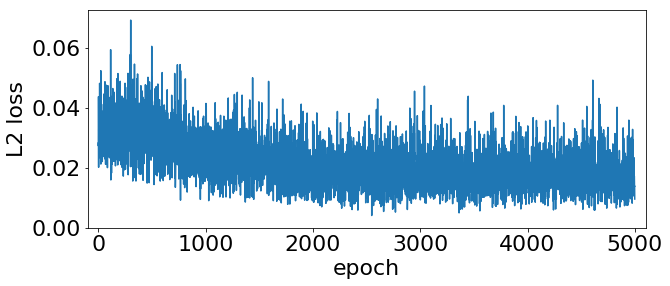

In [123]:
plt.figure(figsize=(10,4))
plt.plot(loss)
plt.ylim(0)
plt.xlim(-100,5100)
plt.ylabel('L2 loss')
plt.xlabel('epoch')

Text(0.5,0,'time')

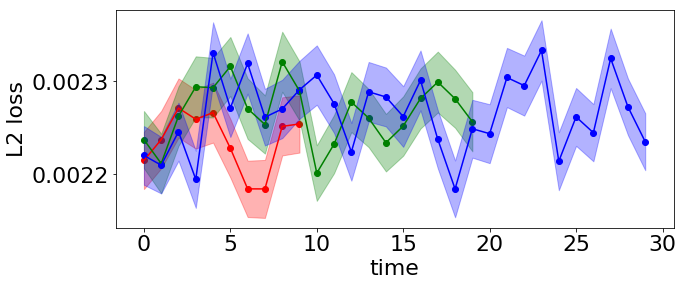

In [168]:
ntrials = 5
# setsize = 4
sdim = net.sedim
eval_lossop = lossop = tr.nn.MSELoss(reduction='none')

plt.figure(figsize=(10,4))

cL = ['r','g','b']
for idx,setsize in enumerate([2,4,6]):

  ## EVALUATE NETWORK
  neps = 5000
  evloss = -np.ones([neps,ntrials*setsize])
  for ep in range(neps):
    S,C,ytarget = task.gen_ep_data(ntrials,setsize)
    yhat = net(S,C)
    eploss = eval_lossop(ytarget.view(-1,sedim),yhat.view(-1,sedim)).mean(-1)
    evloss[ep] = eploss.detach().numpy()

  ## PLOT LOSS
  M = evloss.mean(0)
  T = len(M)
  S = evloss.std(0)/np.sqrt(neps)

  plt.plot(M,c=cL[idx])
  plt.scatter(range(T),M,c=cL[idx])
  plt.fill_between(range(T),M-S,M+S,alpha=.3,color=cL[idx])


plt.ylabel('L2 loss')
plt.xlabel('time')

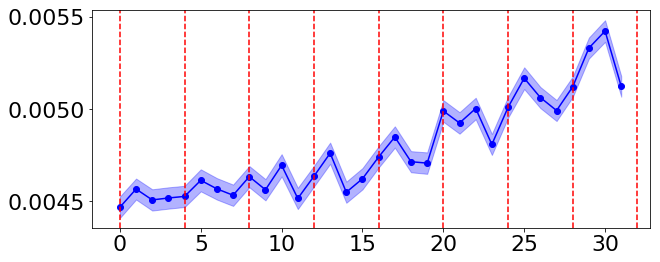

# serial recall 
- ensure forward prop w/o errors

In [44]:
tr.cat([C[0],S[0]],-1).shape

torch.Size([6, 7])

(0, 2.0089862818258246)

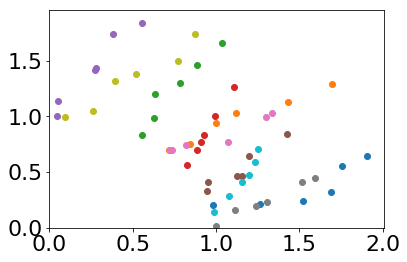

In [34]:
C,S,S = task.gen_ep_data(10,6)
for c in C:
  plt.scatter(c[:,0],c[:,1])
  
plt.ylim(0)
plt.xlim(0)


### model debug

In [37]:
sedim = 5
task = SerialRecallTask(sedim)
indim = 2*sedim
stsize = 20
net = PureEM(indim,stsize)

In [38]:
c,x,y = task.gen_ep_data(2)
x

tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
        [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]])

In [39]:
c,x,y

(tensor([[0.0953, 0.1839, 0.2753, 0.3940, 0.4641],
         [0.0062, 0.0715, 0.0980, 0.2387, 0.4619]]),
 tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
         [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]]),
 tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
         [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]]))

rn


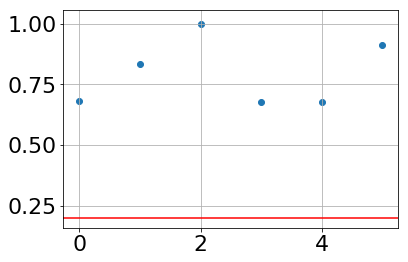

In [54]:
setsize = 6
# temp = 1/(setsize-1)
C,S,Y = task.gen_ep_data(setsize)
# C = np.concatenate([C,S],-1)
x_t = np.array(C[2])
# x_t = np.zeros_like(C[0])
C = np.array(C)
sim = 1-pairwise_distances([x_t],C,metric='euclidean').squeeze()
# sim = np.exp(sim**temp)/np.exp(sim**temp).sum()
# plt.yticks(np.arange(0,1.01,.1))
plt.grid(True)
plt.axhline(1/(setsize-1),c='r')
plt.scatter(range(len(sim)),sim)

## run model

In [2]:
def run_model(net,gen_data_fn,neps,training=False,verb=False):
  """ gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score



In [3]:
nback=2
ntokens=5
cdrift=0.5
cdim=5
sedim=10
indim=cdim+sedim
stsize=20

task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
net = PureEM(nback,indim,stsize,mthresh=.95,seed=132,debug=False)

In [4]:
neps = 2000
seqlen = 10

gen_rand_trials = lambda: task.gen_ep_data(seqlen)
trsc = run_model(net,gen_rand_trials,neps,training=True,verb=False)

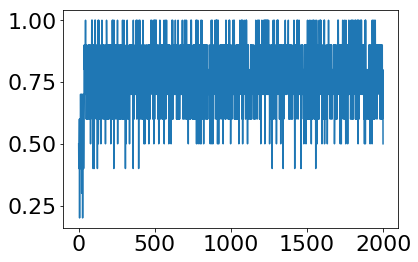

In [5]:
plt.plot(trsc.mean(1))

In [6]:
evsc = run_model(net,gen_rand_trials,500,training=False,verb=False)

(0.5, 1)

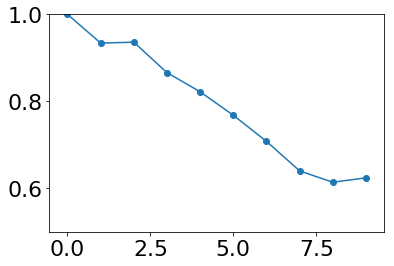

In [7]:
M = evsc.mean(0)
plt.plot(M)
plt.scatter(range(len(M)),M)
plt.ylim(0.5,1)

In [8]:
seqlen=10
evsc = run_model(net,gen_rand_trials,1,training=False,verb=False)

# properties of context drifts

### two step (timescales) context drift
- trial context sampled from first quadrant of unit circle
- linear drift starting from trial context 

## solar drift 2 (multi-trial)
- trial shift
- probe drift

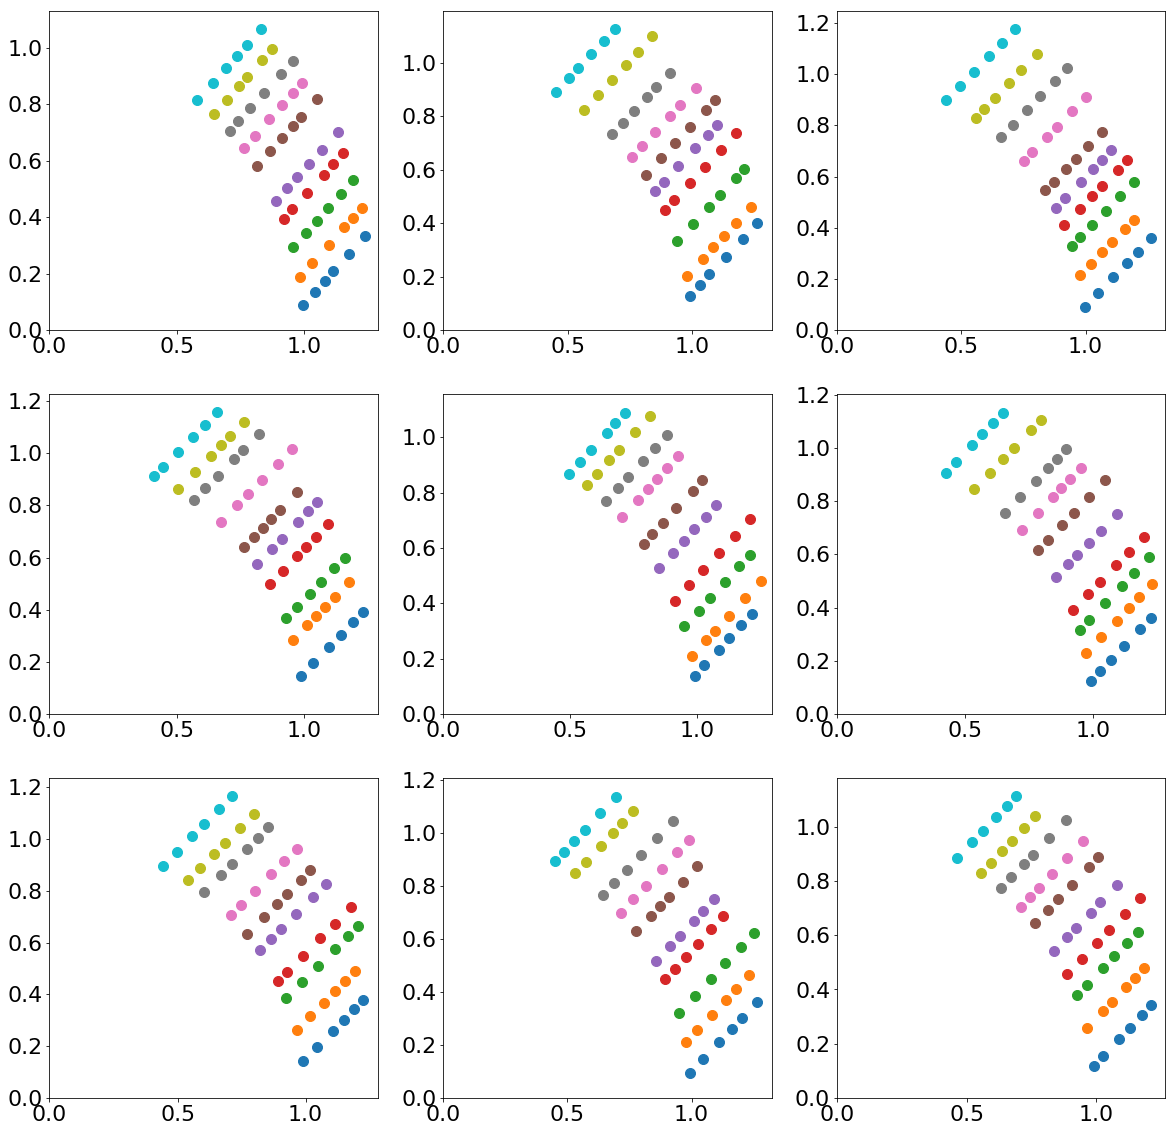

In [114]:
ntrials = 10
ntsteps = 6

# deltas
tstep_drift = lambda: (np.array([1,1]) + np.random.uniform(0,1))/30
trial_shift = lambda: np.random.uniform(0.07,0.15)

fig,axarr = plt.subplots(3,3,figsize=(20,20))

for idx,ax in enumerate(axarr.reshape(-1)):
  # drift shift loop
  context_arr = -np.ones([ntrials,ntsteps,2])
  th = 0
  for trial in range(ntrials):
    th += trial_shift()
    context_t = np.array([np.cos(th),np.sin(th)])
    for tstep in range(ntsteps):
      context_arr[trial,tstep] = context_t
      context_t += tstep_drift()

  for ct in context_arr:
    ax.scatter(ct[:,0],ct[:,1],s=100)

  ax.set_ylim(0)
  ax.set_xlim(0)
plt.savefig('figures/serial_recall/solar_drift-multi_trial_low_noise')

## solar drift 1

In [ ]:
def solar_cdrift():
  # sample initial point
  x_init = np.random.uniform(0,1,[2])
  x_init /= np.linalg.norm(c)
  edim = x_init.shape[-1]
  arr = -np.ones([ntrials,edim])
  x = x_init
  for step in range(ntrials):
    arr[step] = x
    delta_t = np.random.normal(delta_M,cstd,[edim])
    x += np.abs(delta_t)
  return arr

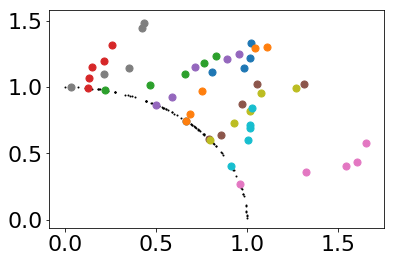

In [5]:
ax = plt.gca()

def sample_trial_context():
  c = np.random.uniform(0,1,[2])
  c /= np.linalg.norm(c)
  return c

def sample_probe_drift(x_init,ntrials,delta_M=.1,cstd=0.1):
    """ 
    drifts ~N(1,self.cstd)
    returns a context embedding matrix [ntrials,cedim]
    """
    edim = x_init.shape[-1]
    arr = -np.ones([ntrials,edim])
    x = x_init
    for step in range(ntrials):
      arr[step] = x
      delta_t = np.random.normal(delta_M,cstd,[edim])
      x += np.abs(delta_t)
    return arr
  
def solar_cdrift(ntrials,delta_M=.1,cstd=0.1):
  # sample initial point
  x_init = np.random.uniform(0,1,[2])
  x_init /= np.linalg.norm(x_init)
  edim = x_init.shape[-1]
  arr = -np.ones([ntrials,edim])
  x = x_init
  for step in range(ntrials):
    arr[step] = x
    delta_t = np.random.normal(delta_M,cstd,[edim])
    x += np.abs(delta_t)
  return arr
  
# make sun
for i in range(100):
  x = sample_trial_context()
  ax.scatter(x[0],x[1],c='k',s=1)

# sample 10 solar drifts
for i in range(10):
#   context_init = sample_trial_context()
#   context = sample_probe_drift(context_init,5)
  context = solar_cdrift(5)
  ax.scatter(context[:,0],context[:,1],s=50)

# plt.savefig('figures/solar_cdrift')

### context drift on sphere: cosine on context retrieves local neighborhood 

In [150]:
def sphere_drift(ntrials,noise=0.05):
    """
    drift on a two dimensional sphere 
    returns C [ntrials,2]
    """
    th = np.pi/(2*ntrials) # drift rate
    R = np.array([[np.cos(th),-np.sin(th)],
                  [np.sin(th),np.cos(th)]])
    x = np.array([1,0]) # initial vector
    C = np.zeros([ntrials,2]) # context matrix
    for i in range(ntrials):
      x = R.dot(x) + np.random.normal(0,noise)
      x = x/np.linalg.norm(x)
      C[i] = x
    return C

# C = sphere_drift(10,.05)
# plt.scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(20*np.arange(len(C))))


(10, 2) (10, 3)


Text(0.5,1,'drift process')

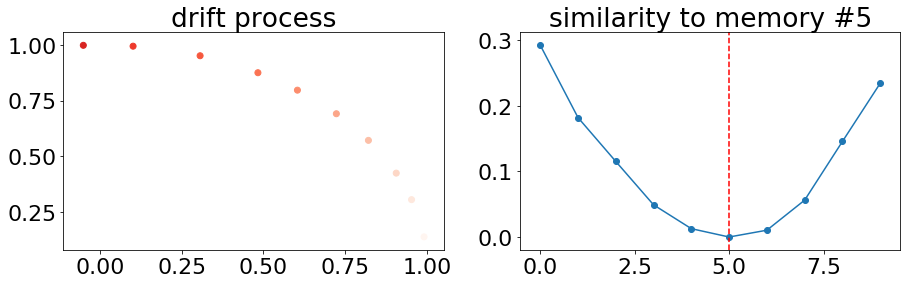

In [159]:
setsize = 10
sdim=3

C = sphere_drift(setsize)
S = np.random.uniform(0,1,[setsize,sdim])
print(C.shape,S.shape)
# C = np.concatenate([C,S],-1)

r_t = 5
c_t = C[r_t]

sim = pairwise_distances([c_t],C,metric='cosine')
sim = sim.squeeze()
fig,axarr = plt.subplots(1,2,figsize=(15,4))
axarr[1].axvline(r_t,c='r',ls='--')
axarr[1].plot(sim)
axarr[1].scatter(range(len(sim)),sim)
axarr[0].scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(20*np.arange(len(C))))
axarr[1].set_title('similarity to memory #5')
axarr[0].set_title('drift process')
# plt.savefig('figures/serial_recall/2Dsphere_context_drift')

### cumsum drift, eucledian retrieval on cat([s,t])

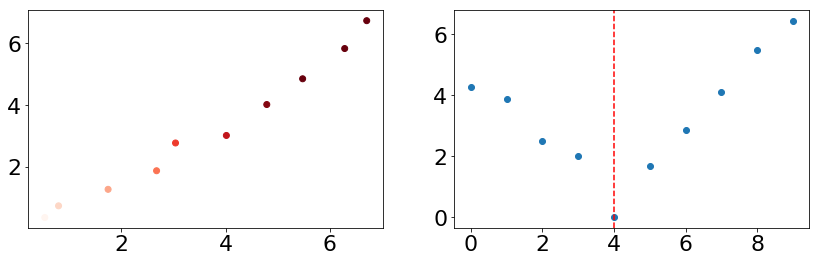

In [3]:
fig,axarr = plt.subplots(1,2,figsize=(14,4))
setsize=10
sdim = 4

S = np.random.uniform(0,1,[setsize,sdim])
C = np.cumsum(np.abs(S),0)
MK = np.concatenate([C,S],-1)

ax = axarr[0]
ax.scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(40*np.arange(len(C))))

ax = axarr[1]
r_t = 4
sim = pairwise_distances([MK[r_t]],MK,metric='euclidean').squeeze()
ax.scatter(range(len(sim)),sim)
ax.axvline(r_t,c='r',ls='--')

### orthogonal cumsum context drift

In [ ]:
M = np.random.randn(2,3)
U,M,V = np.linalg.svd(M)
A = np.matmul(U.T,U)

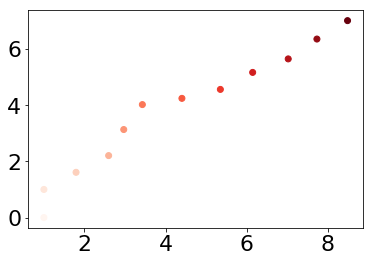

In [78]:
for i in range(10):
  a,b = np.abs(np.random.randn(2))
  P = a*A[:,0:1]+b*A[:,1:2]
  P = P/np.linalg.norm(P)
  A = np.concatenate([A,P],1)
  
C = np.cumsum(A,1).T
plt.scatter(C[:,0],C[:,1],c=np.arange(len(C))+10,cmap=plt.get_cmap('Reds'))

### under what conditions of the stimulus matrix, will the context be a gradual drift?
- as long as non-negative

### how can I use stim to query context, and get neighborhood of stim?
- ??